# Estimate the Gas Mass

This notebook details methods used to obtain an estimate for the mass of the cold ALMA gas. We ectract S/N > 2 emission from each aperture and fit the spectra using pyspeckit. The result is used to estimate the h2 gas mass and depeltion time. We fit the profiles using a `single gaussian`

`the spectral fitting hasnt been done well using single gaussian`

In [1]:
#path to beads
my_path = '/Users/osaseomoruyi/Dropbox (Harvard University)/BeadsMultiwavelength/'

In [2]:
#system
from __future__ import division
import sys
import importlib

#numpy
import numpy as np

#astropy
from astropy.cosmology import LambdaCDM
import astropy.units as u
from astropy.coordinates import Angle
import astropy.constants as const

#matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

#pv stuff

from spectral_cube import SpectralCube

#seaborn
import seaborn as sns

#warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
#import my own functions: you can see them in full in the utils folder
util_path = my_path + 'Notebooks/Beads20/utils/'
sys.path.append(util_path)

import plotting_functions as pf
import alma_functions as af

In [4]:
#importlib.reload(pf)

<module 'plotting_functions' from '/Users/osaseomoruyi/Dropbox (Harvard University)/BeadsMultiwavelength/Notebooks/Beads20/utils/plotting_functions.py'>

In [4]:
#About
name = 'SDSS J1531+3414'
ra = 232.7936938
dec = 34.2404172
radius = Angle(2.5, u.arcsec)

zh  = 0.335 #z selected from Hennawi (2008)
cz = zh * const.c.to('km/s')

In [5]:
cosmo = LambdaCDM(H0=71, Om0=0.27, Ode0=0.73)
da = cosmo.angular_diameter_distance(zh)
dl = cosmo.luminosity_distance(zh)

In [6]:

file_path = 'Analysis/almaBeads/cannon/'
co32_file = my_path + 'Analysis/almaBeads/reduced_2022/SDSS1531_CO32_20kms_natural_notaper.image.pbcor.fits'

m0_file = my_path + 'Analysis/almaBeads/reduced_2022/SDSS1531_CO32_20kms_natural_notaper.image.pbcor_M0.fits'

fig_path = my_path + 'Figures/paper/'

In [7]:
#plot style
#pf.styleplots(presentation=True)

## Estimate gas mass for cubes binned to different velocities
We used the ALMA data reduction pipeline to bin the ALMA cubes to different velocity resolutions of 10, 20, 40 and 80 km/s. We will obtain a gas mass estimate for each of these bins, to check if binning impacts our estimates by a significant amount


In [8]:
#list of cubes
velocity_resolutions = [10, 20, 40, 80]

vcube_files = [''.join((my_path, 'Analysis/almaBeads/reduced_2022/SDSS1531_CO32_{}kms_natural_notaper'
                        '.image.pbcor.fits'.format(vel))) for vel in velocity_resolutions]


In [9]:
#moment files for each cube
m0_files = [vfile[:-5]+ '_M0.fits' for vfile in vcube_files]
m1_files = [vfile[:-5]+ '_M1.fits' for vfile in vcube_files]
m2_files = [vfile[:-5]+ '_M2.fits' for vfile in vcube_files]

### Extract Spectra using Spectral-Cube and DS9

First, we draw apertures around the area we would like to fit using the mom0 map in DS9


In [49]:
region_string=""""
# Region file format: DS9 version 4.1
global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1
fk5
ellipse(232.7936870,34.2403494,0.977",1.532",337.76158)
ellipse(232.7938088,34.2398737,1.554",1.936",325.57376)
ellipse(232.7940692,34.2397661,0.834",1.474",19.996095)
ellipse(232.7937700,34.2400595,1.702",2.613",345.09165)
"""

In [50]:
m0cmap, m1cmap, m2cmap =sns.light_palette("seagreen", as_cmap=True), cm.Blues,  sns.color_palette("mako_r", as_cmap=True)

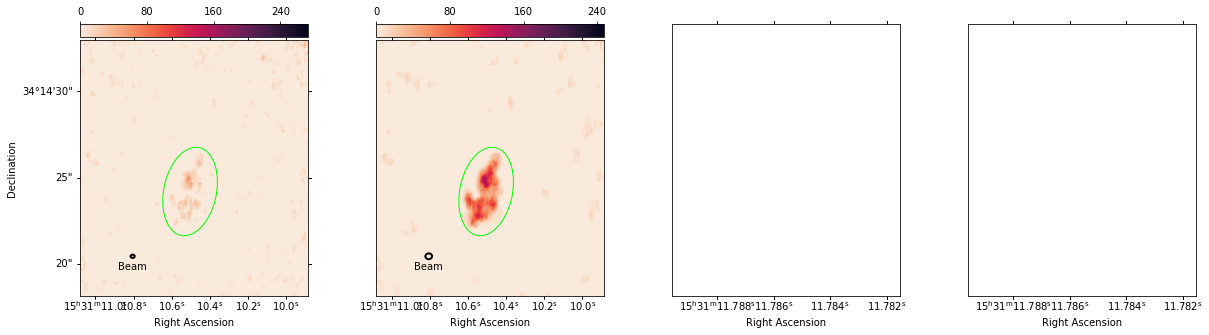

In [51]:
hdu, header, wcs = pf.open_fits(m0_files[0], naxis=2)
fig = pf.plot_all_moments(m0_files, header, region_string=region_string, ncols=4)

We can't resolve the individual beads, but `notebook 1` showed us there are 3 coherent structures present. We'll refer to them as `north, center and south`

In [13]:
lines = region_string.splitlines(keepends=False)[4:]
n_region = 'fk5; {}'.format(lines[0])
c_region = 'fk5; {}'.format(lines[1])
s_region = 'fk5; {}'.format(lines[2])
t_region = 'fk5; {}'.format(lines[3])

select emission in each region, for all 4 velocity resolutions

In [14]:
regions = [n_region, c_region, s_region, t_region]
velocity_ranges = [[20, 220], [230, 440], [450, 660], [-680, 900]]
vaperture_cubes = []

for idv, vfile in enumerate(vcube_files):

    cube = SpectralCube.read(vfile)
    
    aperture_cubes = []

    for idr, region_type in enumerate(regions):
        
        vmin, vmax = velocity_ranges[idr][0], velocity_ranges[idr][1]
        subcube = cube.spectral_slab(vmin *(u.km/u.s), vmax*(u.km/u.s))
        ap_cube = subcube.subcube_from_ds9region(region_type) 

        aperture_cubes.append(ap_cube)
    
    vaperture_cubes.append(aperture_cubes)

In [15]:
north_region_cubes = [cube_list[0] for cube_list in vaperture_cubes]
center_region_cubes = [cube_list[1] for cube_list in vaperture_cubes]
south_region_cubes = [cube_list[2] for cube_list in vaperture_cubes]
total_region_cubes = [cube_list[3] for cube_list in vaperture_cubes]

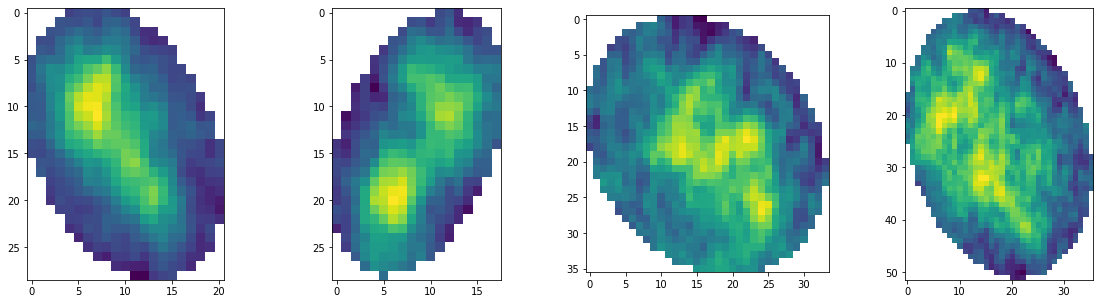

In [16]:
#check that the areas selected are correct
fig, axs = plt.subplots(1,4,figsize=(20, 5))
axs.ravel()

plot_cubes = [north_region_cubes, south_region_cubes, center_region_cubes, total_region_cubes]

for idx, ax in enumerate(axs):
    plot_cube = plot_cubes[idx]
    ax.imshow(plot_cube[2].moment(order=0).data)

### Fit the spectra with pyspeckit with a single Gaussian fit and estimate masses

why do the errors only make sense when I set direct=False for the integral in pyspeckit?


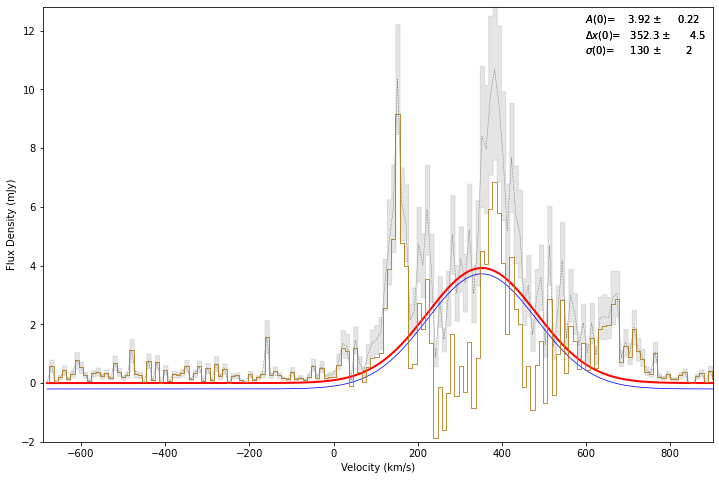

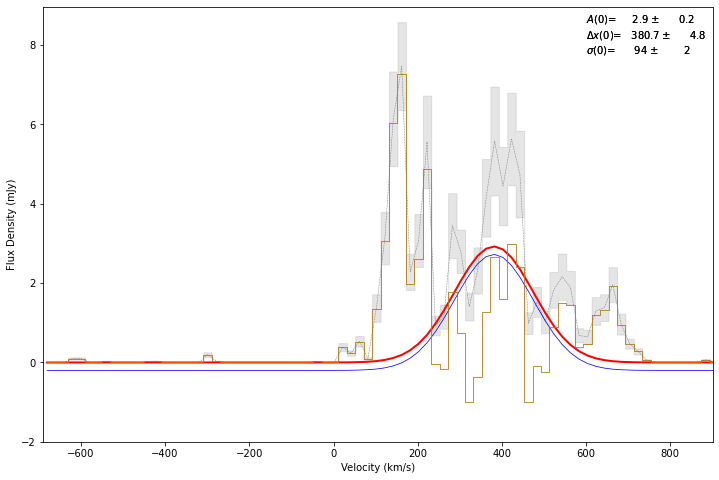

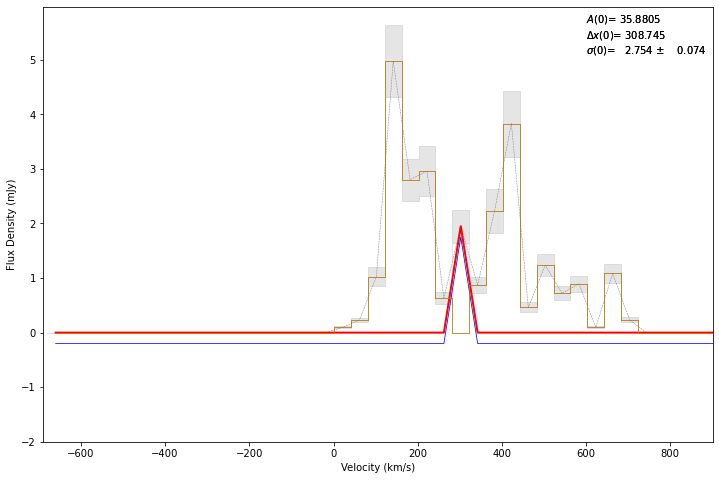

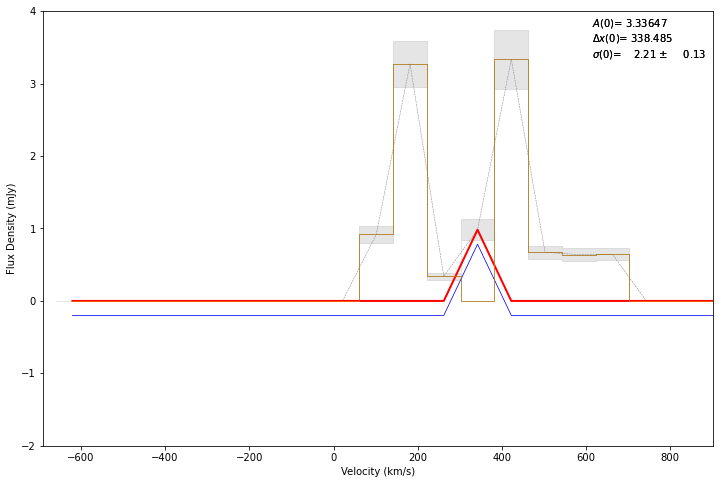

In [24]:
tot_integrals = []
tot_errs= []
tot_figs = []


xminval,xmaxval = -690, 900

for idt, tcube in enumerate(total_region_cubes):
# idt=1
# tcube=totcubes[idt]
    fig, ax, tot_integral, tot_err, tot_components= af.spec_integral(tcube, guesses=None, lcolor='cyan', 
                                                                        sigma=3, annotate=True, direct=False, 
                                                                        xminval=xminval, xmaxval=xmaxval)#, cube_rms=cube_rms)
    tot_integrals.append(tot_integral)
    tot_errs.append(tot_err)
    tot_figs.append(fig)

In [20]:
#tot_figs[1].savefig(fig_path + 'ALMA_Total_Aperture_Gas_Mass.pdf', dpi=100)

The guesses give okay fits for the total region. Now estimate masses

In [21]:
tot_masses = []
tot_err_masses =[]

for idi, integral in enumerate(tot_integrals):
    print("\nTotal Aperture, Bin {} km/s:\nSCO Delta V = {:.2f} +/- {:.2f} mJy km/s".format(velocity_resolutions[idi], integral, tot_errs[idi]))
    
    integral_units = ((u.mJy * u.km)/u.s)
    tot_mass = af.mass_time(integral * integral_units, tot_errs[idi] * integral_units, 5)
    #print("\nerror:")
    #terr_mass = af.mass_time(tot_errs[idi] * ((u.mJy * u.km)/u.s), 5)
    tot_masses.append(tot_mass)


Total Aperture, Bin 10 km/s:
SCO Delta V = 1272.83 +/- 99.69 mJy km/s
H2 mass: 2.82E+10 solMass +/- 2.21E+09 solMass
5.0 solMass / yr
t_dep : 5.65E+00 Gyr 

Total Aperture, Bin 20 km/s:
SCO Delta V = 686.43 +/- 76.79 mJy km/s
H2 mass: 1.52E+10 solMass +/- 1.70E+09 solMass
5.0 solMass / yr
t_dep : 3.05E+00 Gyr 

Total Aperture, Bin 40 km/s:
SCO Delta V = 78.14 +/- 12.24 mJy km/s
H2 mass: 1.73E+09 solMass +/- 2.72E+08 solMass
5.0 solMass / yr
t_dep : 3.47E-01 Gyr 

Total Aperture, Bin 80 km/s:
SCO Delta V = 78.79 +/- 11.55 mJy km/s
H2 mass: 1.75E+09 solMass +/- 2.56E+08 solMass
5.0 solMass / yr
t_dep : 3.50E-01 Gyr 


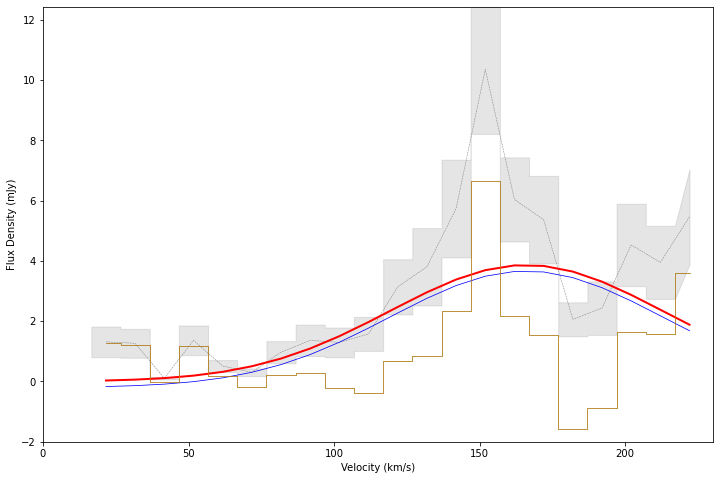

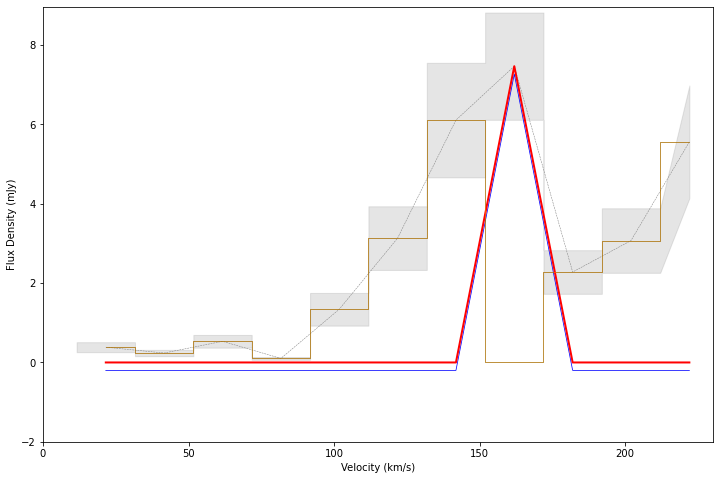

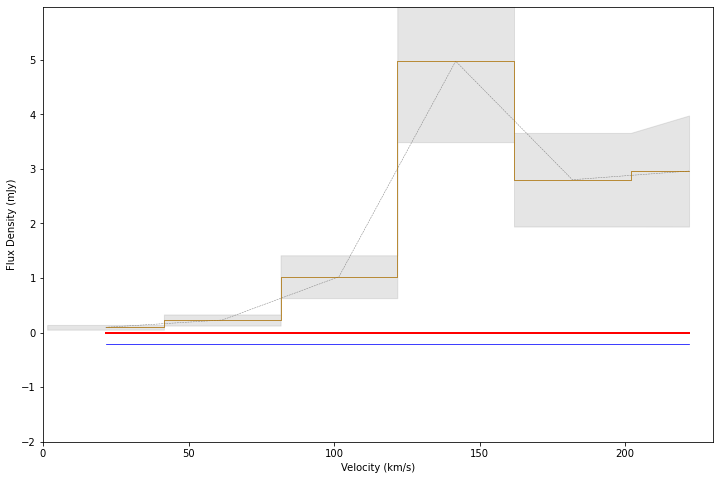

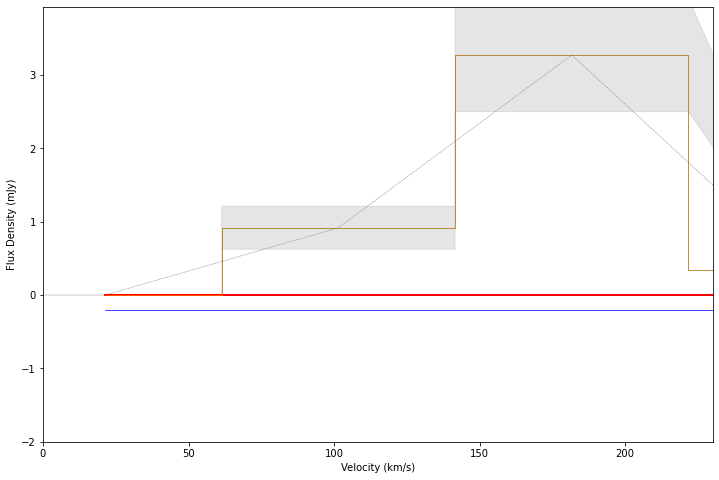

In [25]:
north_integrals = []
north_errs = []
north_figs = []


xminval, xmaxval = 0, 230
for idn, ncube in enumerate(north_region_cubes):
# idn=3
# ncube=ncubes[idn]

    fig, ax, north_integral, north_err, north_component = af.spec_integral(ncube, guesses=None, xminval=xminval, xmaxval=xmaxval, sigma=3)
    north_integrals.append(north_integral)
    north_errs.append(north_err)
    north_figs.append(fig)

These fits are ok

In [26]:
#north_figs[1].savefig(fig_path + 'ALMA_Northern_Aperture_Gas_Mass.pdf', dpi=100)

In [27]:
north_masses = []

for idi, integral in enumerate(north_integrals):
    print("\nNorth Aperture, Bin {} km/s:\nSCO Delta V = {:.2f} +/- {:.2f} mJy km/s".format(velocity_resolutions[idi], integral, north_errs[idi]))
    
    north_mass = af.mass_time(integral * integral_units, north_errs[idi] * integral_units, 5)
    north_masses.append(north_mass)


North Aperture, Bin 10 km/s:
SCO Delta V = 409.18 +/- 47.20 mJy km/s
H2 mass: 9.08E+09 solMass +/- 1.05E+09 solMass
5.0 solMass / yr
t_dep : 1.82E+00 Gyr 

North Aperture, Bin 20 km/s:
SCO Delta V = 149.71 +/- 27.10 mJy km/s
H2 mass: 3.32E+09 solMass +/- 6.02E+08 solMass
5.0 solMass / yr
t_dep : 6.64E-01 Gyr 

North Aperture, Bin 40 km/s:
SCO Delta V = 0.00 +/- 34.37 mJy km/s
H2 mass: 2.94E-58 solMass +/- 7.63E+08 solMass
5.0 solMass / yr
t_dep : 5.88E-68 Gyr 

North Aperture, Bin 80 km/s:
SCO Delta V = 0.00 +/- 61.89 mJy km/s
H2 mass: 4.34E-65 solMass +/- 1.37E+09 solMass
5.0 solMass / yr
t_dep : 8.67E-75 Gyr 


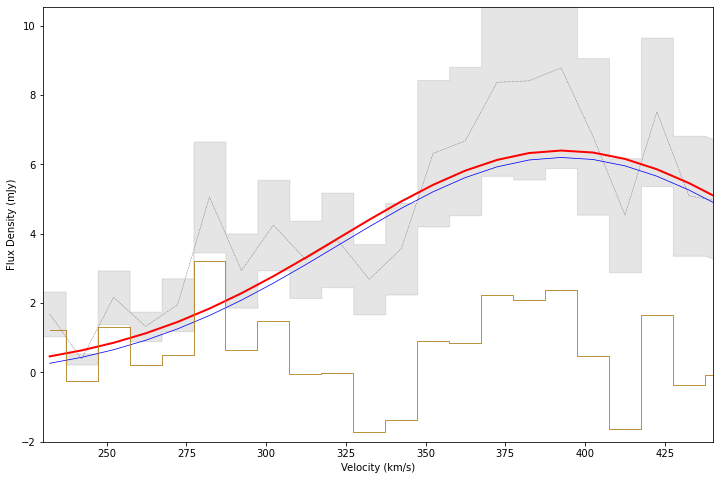

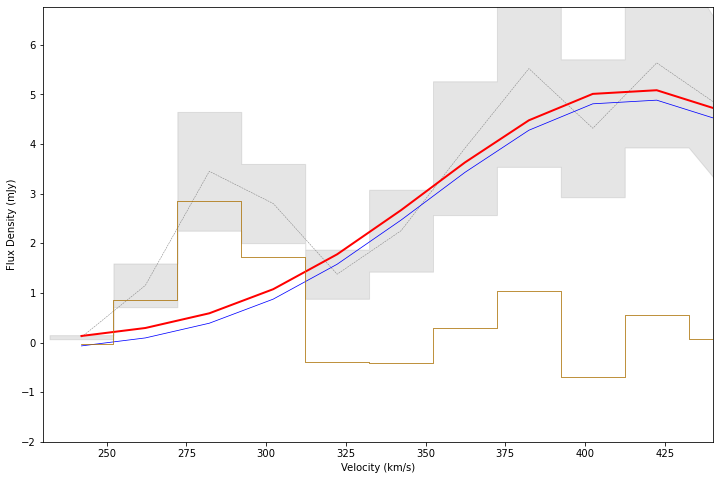

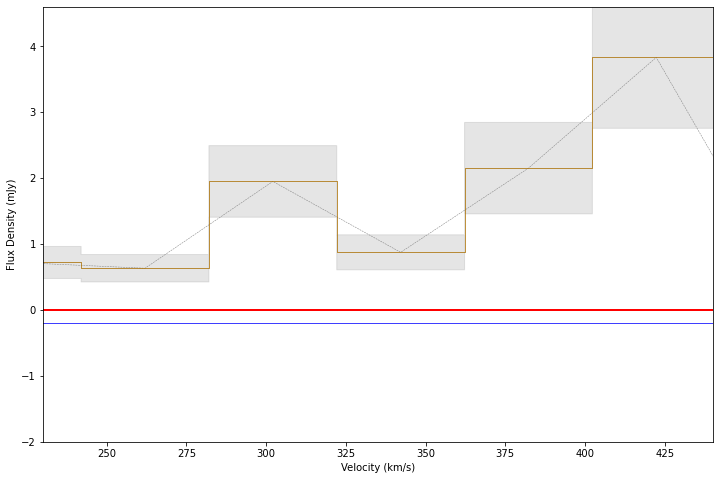

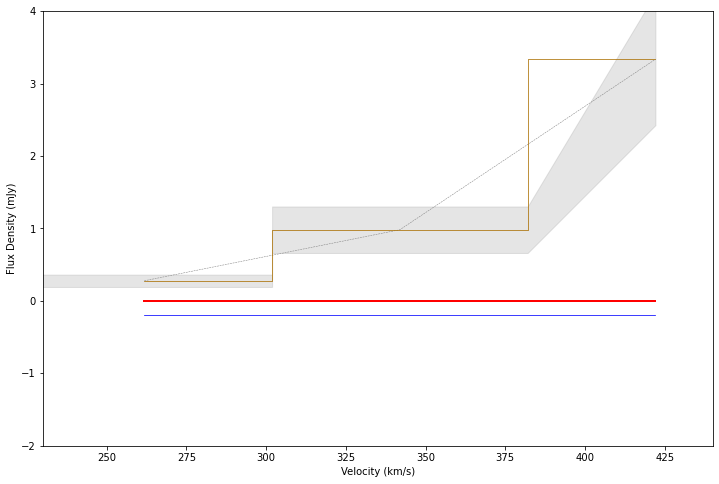

In [28]:
center_integrals = []
center_errs = []
center_figs = []

xminval, xmaxval = 230, 440
for idn, ccube in enumerate(center_region_cubes):
# idn=3
# ncube=ncubes[idn]

    fig, ax, center_integral, center_err, center_component = af.spec_integral(ccube, guesses=None, xminval=xminval, xmaxval=xmaxval, sigma=3)
    center_integrals.append(center_integral)
    center_errs.append(center_err)
    center_figs.append(fig)

In [29]:
center_masses = []

for idi, integral in enumerate(center_integrals):
    print("\nCenter Aperture, Bin {} km/s:\nSCO Delta V = {:.2f} +/- {:.2f} mJy km/s".format(velocity_resolutions[idi], integral, center_errs[idi]))
    
    center_mass = af.mass_time(integral * integral_units, center_errs[idi] * integral_units, 5)
    center_masses.append(center_mass)


Center Aperture, Bin 10 km/s:
SCO Delta V = 869.73 +/- 80.25 mJy km/s
H2 mass: 1.93E+10 solMass +/- 1.78E+09 solMass
5.0 solMass / yr
t_dep : 3.86E+00 Gyr 

Center Aperture, Bin 20 km/s:
SCO Delta V = 589.27 +/- 80.95 mJy km/s
H2 mass: 1.31E+10 solMass +/- 1.80E+09 solMass
5.0 solMass / yr
t_dep : 2.62E+00 Gyr 

Center Aperture, Bin 40 km/s:
SCO Delta V = 0.00 +/- 27.80 mJy km/s
H2 mass: 2.22E-49 solMass +/- 6.17E+08 solMass
5.0 solMass / yr
t_dep : 4.44E-59 Gyr 

Center Aperture, Bin 80 km/s:
SCO Delta V = 0.00 +/- 0.00 mJy km/s
H2 mass: 0.00E+00 solMass +/- 0.00E+00 solMass
5.0 solMass / yr
t_dep : 0.00E+00 Gyr 


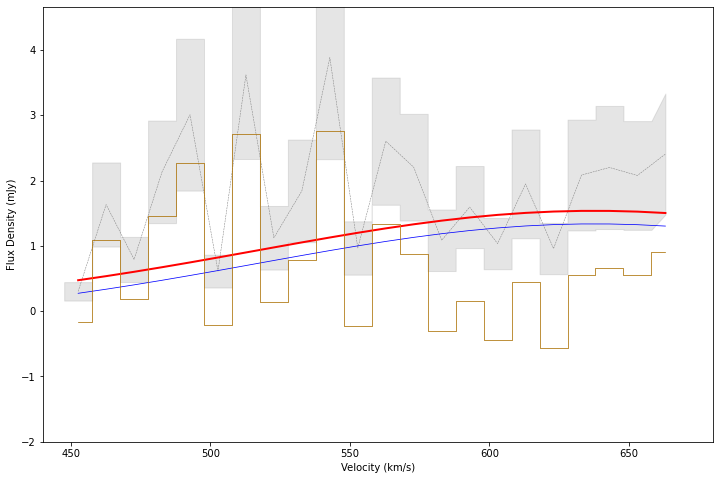

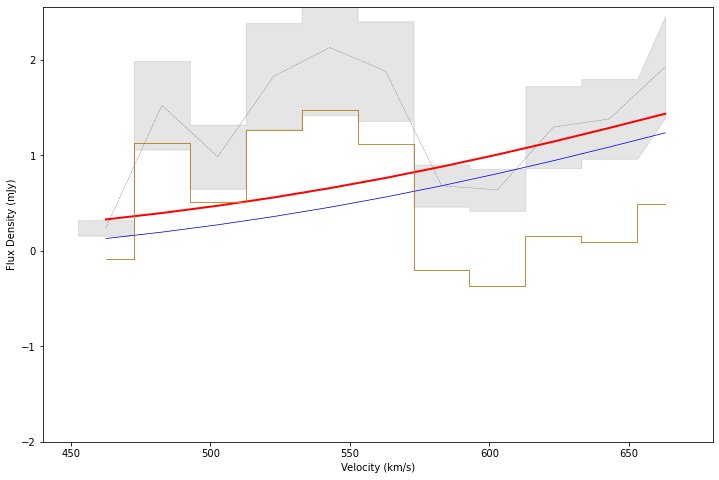

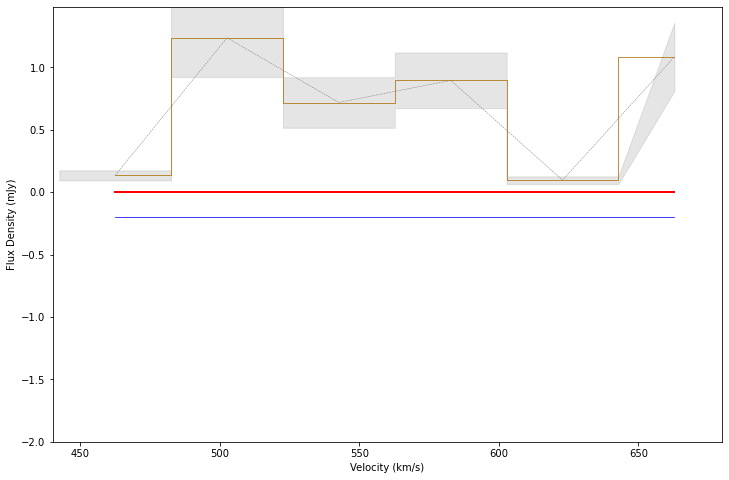

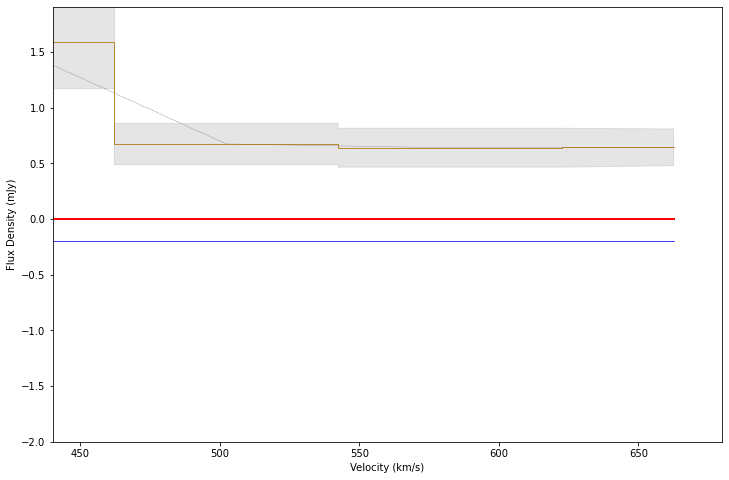

In [30]:
south_integrals = []
south_errs =[]
south_figs= []
southguesses=[]


xminval, xmaxval=440, 680

for ids, scube in enumerate(south_region_cubes):

    fig, ax, south_integral, south_err, south_component = af.spec_integral(scube, guesses=None, sigma=3, xminval=xminval, xmaxval=xmaxval)
    south_integrals.append(south_integral)
    south_errs.append(south_err)
    south_figs.append(fig)

This fit is also ok

In [31]:
south_masses = []

for idi, integral in enumerate(south_integrals):
    print("\nSouthern Aperture, Bin {} km/s:\nSCO Delta V = {:.2f} +/- {:.2f} mJy km/s".format(velocity_resolutions[idi], integral, south_errs[idi]))
    
    south_mass = af.mass_time(integral * integral_units, south_errs[idi] * integral_units, 5)
    south_masses.append(south_mass)


Southern Aperture, Bin 10 km/s:
SCO Delta V = 251.82 +/- 37.60 mJy km/s
H2 mass: 5.59E+09 solMass +/- 8.34E+08 solMass
5.0 solMass / yr
t_dep : 1.12E+00 Gyr 

Southern Aperture, Bin 20 km/s:
SCO Delta V = 179.26 +/- 29.46 mJy km/s
H2 mass: 3.98E+09 solMass +/- 6.54E+08 solMass
5.0 solMass / yr
t_dep : 7.96E-01 Gyr 

Southern Aperture, Bin 40 km/s:
SCO Delta V = 0.00 +/- 8.93 mJy km/s
H2 mass: 2.11E-11 solMass +/- 1.98E+08 solMass
5.0 solMass / yr
t_dep : 4.23E-21 Gyr 

Southern Aperture, Bin 80 km/s:
SCO Delta V = 0.00 +/- 14.77 mJy km/s
H2 mass: 1.86E-07 solMass +/- 3.28E+08 solMass
5.0 solMass / yr
t_dep : 3.73E-17 Gyr 


## Does Weighting Impact Gas Mass?

Brigss Weighting halves the SCO factor, halfing the mass

In [32]:
#list of cubes
vcube_files = []
weights = ['briggs', 'natural']

vcube_files = [''.join((my_path, 'Analysis/almaBeads/reduced_2022/SDSS1531_CO32_20kms_{}_notaper'
                        '.image.pbcor.fits'.format(weight))) for weight in weights]

In [33]:
#moment files for each cube
#moment files for each cube
m0_files = [vfile[:-5]+ '_M0.fits' for vfile in vcube_files]
m1_files = [vfile[:-5]+ '_M1.fits' for vfile in vcube_files]
m2_files = [vfile[:-5]+ '_M2.fits' for vfile in vcube_files]

### Extract Spectra using Spectral-Cube and DS9

First, we draw apertures around the area we would like to fit using the mom0 map in DS9


In [34]:
region_string=""""
# Region file format: DS9 version 4.1
global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1
fk5
ellipse(232.7936870,34.2403494,0.977",1.532",337.76158)
ellipse(232.7938088,34.2398737,1.554",1.936",325.57376)
ellipse(232.7940692,34.2397661,0.834",1.474",19.996095)
ellipse(232.7937700,34.2400595,1.702",2.613",345.09165)
"""

In [35]:
m0cmap, m1cmap, m2cmap =sns.light_palette("seagreen", as_cmap=True), cm.Blues,  sns.color_palette("mako_r", as_cmap=True)

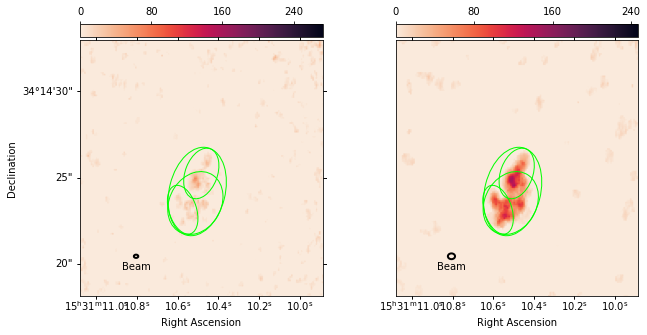

In [36]:
hdu, header, wcs = pf.open_fits(m0_files[0], naxis=2)
fig = pf.plot_all_moments(m0_files, header, region_string=region_string, ncols=2)

We can't resolve the individual beads, but we do see two main cores of gas: one North and the other South. We'll fit all of the emission together, and the emission in the north and south

In [37]:
lines = region_string.splitlines(keepends=False)[4:]
n_region = 'fk5; {}'.format(lines[0])
c_region = 'fk5; {}'.format(lines[1])
s_region = 'fk5; {}'.format(lines[2])
t_region = 'fk5; {}'.format(lines[3])


In [38]:
regions = [n_region, c_region, s_region, t_region]
velocity_ranges = [[20, 220], [230, 440], [450, 660], [-680, 900]]
vaperture_cubes = []

for idv, vfile in enumerate(vcube_files):

    cube = SpectralCube.read(vfile)
    
    aperture_cubes = []

    for idr, region_type in enumerate(regions):
        
        vmin, vmax = velocity_ranges[idr][0], velocity_ranges[idr][1]
        subcube = cube.spectral_slab(vmin *(u.km/u.s), vmax*(u.km/u.s))
        ap_cube = subcube.subcube_from_ds9region(region_type) 

        aperture_cubes.append(ap_cube)
    
    vaperture_cubes.append(aperture_cubes)

In [39]:
north_region_cubes = [cube_list[0] for cube_list in vaperture_cubes]
center_region_cubes = [cube_list[1] for cube_list in vaperture_cubes]
south_region_cubes = [cube_list[2] for cube_list in vaperture_cubes]
total_region_cubes = [cube_list[3] for cube_list in vaperture_cubes]

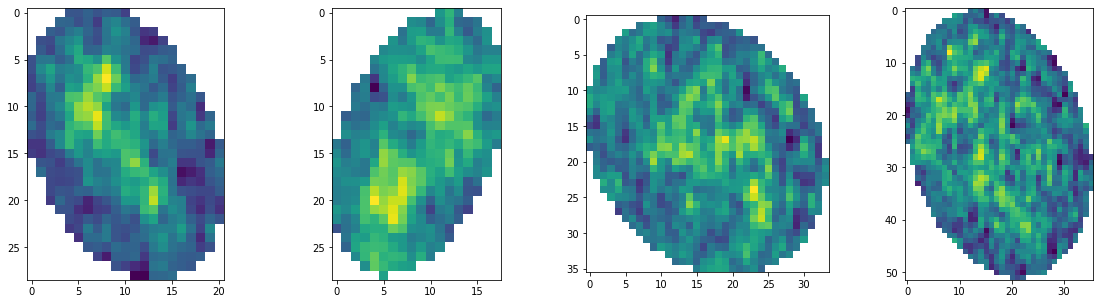

In [40]:
#check that the areas selected are correct
fig, axs = plt.subplots(1,4,figsize=(20, 5))
axs.ravel()

plot_cubes = [north_region_cubes, south_region_cubes, center_region_cubes, total_region_cubes]

for idx, ax in enumerate(axs):
    plot_cube = plot_cubes[idx]
    ax.imshow(plot_cube[0].moment(order=0).data)

### Fit the spectra and estimate masses

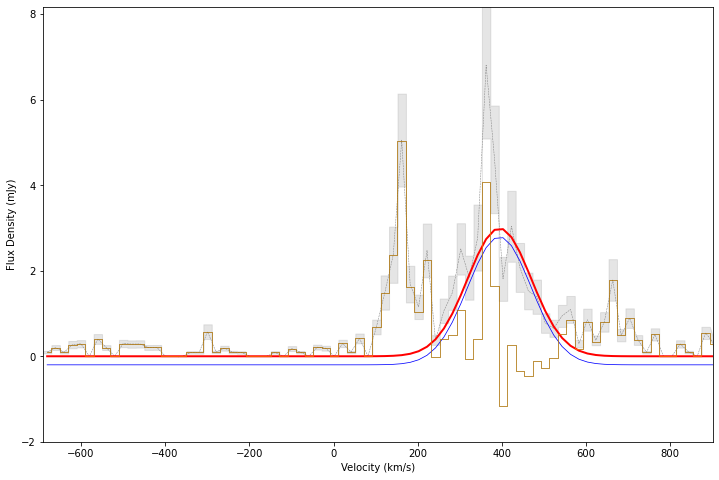

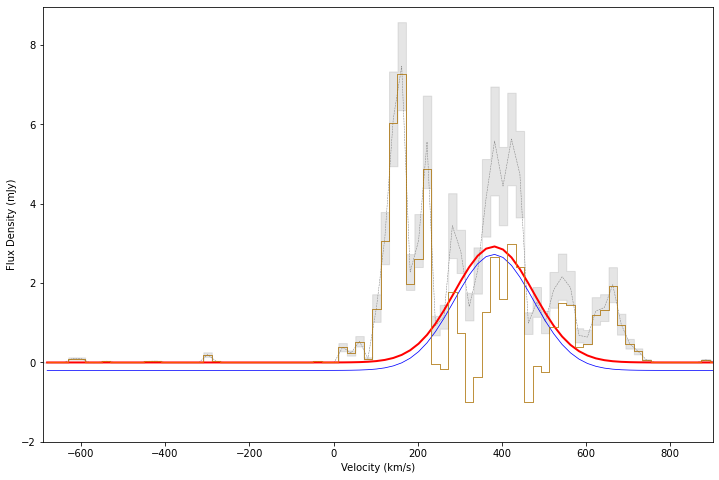

In [41]:
tot_integrals = []
tot_errs= []
tot_figs = []

xminval,xmaxval = -690, 900

for idt, tcube in enumerate(total_region_cubes):
# idt=1
# tcube=totcubes[idt]
    fig, ax, tot_integral, tot_err, tot_components= af.spec_integral(tcube, guesses=None, lcolor='cyan', sigma=3, annotate=False, direct=False, xminval=xminval, xmaxval=xmaxval)#, cube_rms=cube_rms)
    tot_integrals.append(tot_integral)
    tot_errs.append(tot_err)
    tot_figs.append(fig)

In [42]:
tot_masses = []
tot_err_masses =[]

for idi, integral in enumerate(tot_integrals):
    print("\nTotal Aperture, {} Weighting:\nSCO Delta V = {:.2f} +/- {:.2f} mJy km/s".format(weights[idi], integral, tot_errs[idi]))
    
    integral_units = ((u.mJy * u.km)/u.s)
    tot_mass = af.mass_time(integral * integral_units, tot_errs[idi] * integral_units, 5)
    #print("\nerror:")
    #terr_mass = af.mass_time(tot_errs[idi] * ((u.mJy * u.km)/u.s), 5)
    tot_masses.append(tot_mass)


Total Aperture, briggs Weighting:
SCO Delta V = 565.99 +/- 58.93 mJy km/s
H2 mass: 1.26E+10 solMass +/- 1.31E+09 solMass
5.0 solMass / yr
t_dep : 2.51E+00 Gyr 

Total Aperture, natural Weighting:
SCO Delta V = 686.43 +/- 76.79 mJy km/s
H2 mass: 1.52E+10 solMass +/- 1.70E+09 solMass
5.0 solMass / yr
t_dep : 3.05E+00 Gyr 


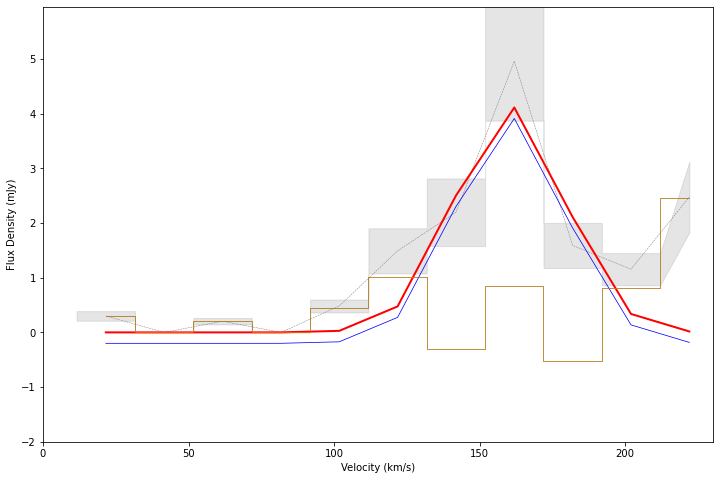

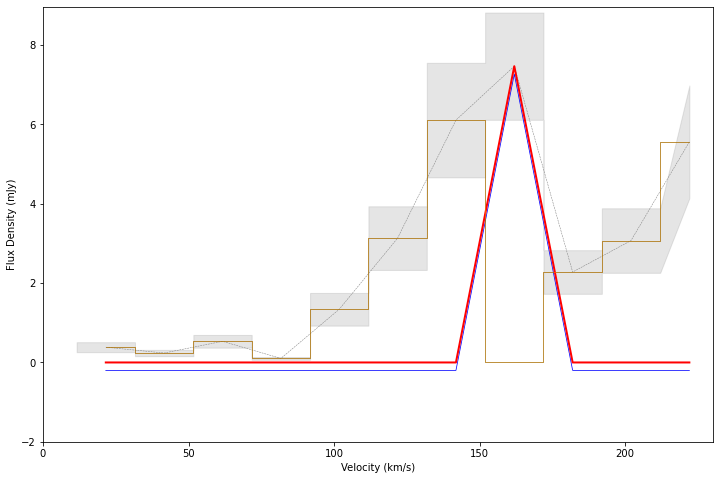

In [43]:
north_integrals = []
north_errs = []
north_figs = []

xminval, xmaxval = 0, 230
for idn, ncube in enumerate(north_region_cubes):
# idn=3
# ncube=ncubes[idn]
    northguess = None

    fig, ax, north_integral, north_err, north_component = af.spec_integral(ncube, guesses=northguess, xminval=xminval, xmaxval=xmaxval, sigma=3)
    north_integrals.append(north_integral)
    north_errs.append(north_err)
    north_figs.append(fig)

In [44]:
north_masses = []

for idi, integral in enumerate(north_integrals):
    print("\nNorth Aperture, {} Weighting :\nSCO Delta V = {:.2f} +/- {:.2f} mJy km/s".format(weights[idi], integral, north_errs[idi]))
    
    north_mass = af.mass_time(integral * integral_units, north_errs[idi] * integral_units, 5)
    north_masses.append(north_mass)


North Aperture, briggs Weighting :
SCO Delta V = 191.95 +/- 28.28 mJy km/s
H2 mass: 4.26E+09 solMass +/- 6.28E+08 solMass
5.0 solMass / yr
t_dep : 8.52E-01 Gyr 

North Aperture, natural Weighting :
SCO Delta V = 149.71 +/- 27.10 mJy km/s
H2 mass: 3.32E+09 solMass +/- 6.02E+08 solMass
5.0 solMass / yr
t_dep : 6.64E-01 Gyr 


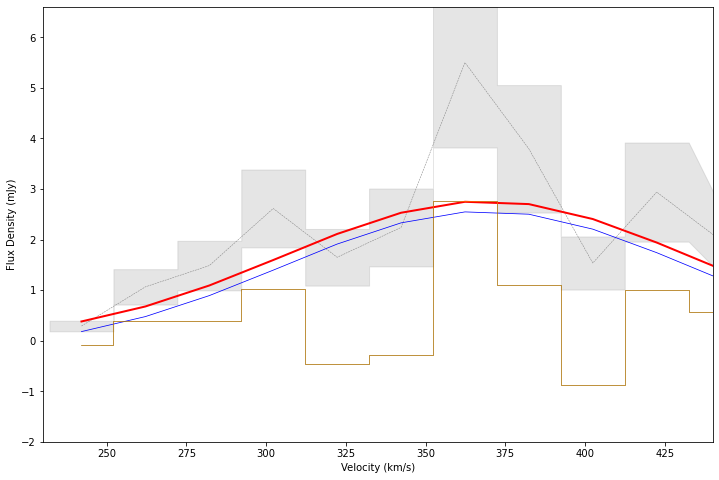

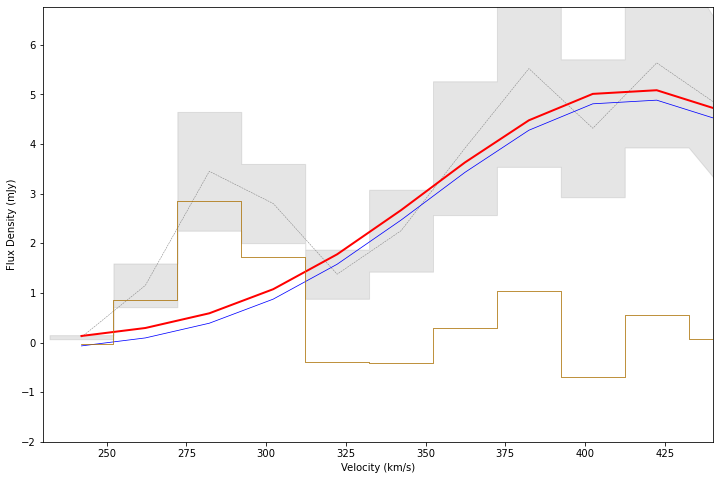

In [45]:
center_integrals = []
center_errs = []
center_figs = []


xminval, xmaxval = 230, 440
for idn, ncube in enumerate(center_region_cubes):
# idn=3
# ncube=ncubes[idn]
    northguess = None

    fig, ax, center_integral, center_err, center_component = af.spec_integral(ncube, guesses=northguess, xminval=xminval, xmaxval=xmaxval, sigma=3)
    center_integrals.append(center_integral)
    center_errs.append(center_err)
    center_figs.append(fig)

In [46]:
center_masses = []

for idi, integral in enumerate(center_integrals):
    print("\nNorth Aperture, {} Weighting :\nSCO Delta V = {:.2f} +/- {:.2f} mJy km/s".format(weights[idi], integral, center_errs[idi]))
    
    center_mass = af.mass_time(integral * integral_units, center_errs[idi] * integral_units, 5)
    center_masses.append(center_mass)


North Aperture, briggs Weighting :
SCO Delta V = 392.84 +/- 56.58 mJy km/s
H2 mass: 8.72E+09 solMass +/- 1.26E+09 solMass
5.0 solMass / yr
t_dep : 1.74E+00 Gyr 

North Aperture, natural Weighting :
SCO Delta V = 589.27 +/- 80.95 mJy km/s
H2 mass: 1.31E+10 solMass +/- 1.80E+09 solMass
5.0 solMass / yr
t_dep : 2.62E+00 Gyr 


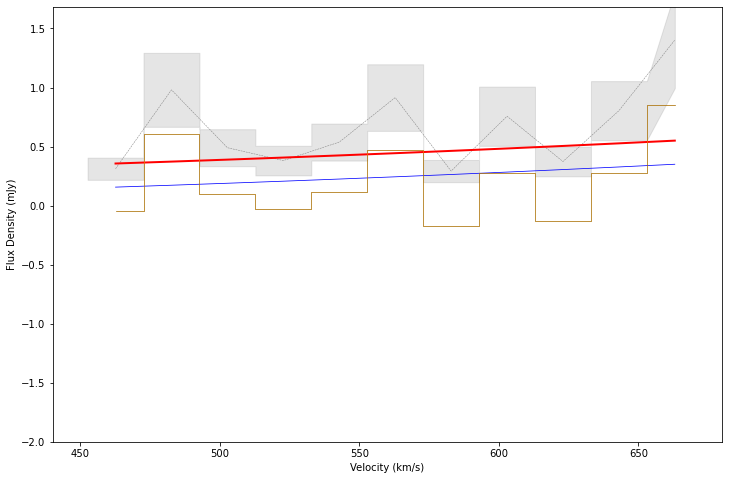

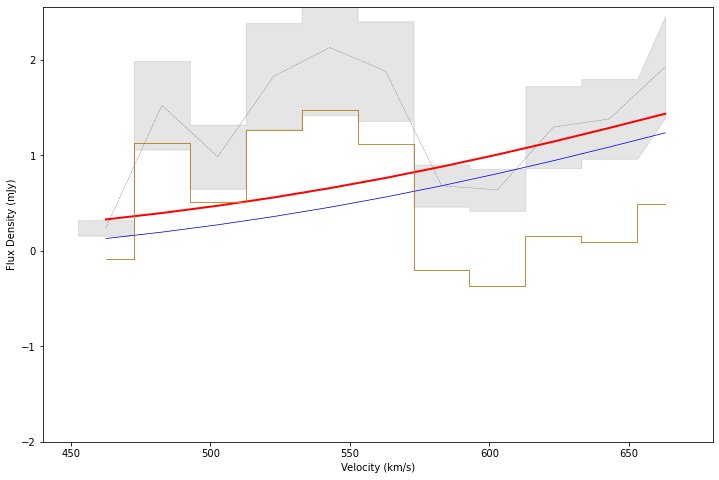

In [47]:
south_integrals = []
south_errs =[]
south_figs= []
southguesses=[]
# for scube in scubes:

xminval, xmaxval=440, 680

for ids, scube in enumerate(south_region_cubes):

# ids = 2
# scube = scubes[ids]
    southguess = None

    fig, ax, south_integral, south_err, south_component = af.spec_integral(scube, guesses=southguess, sigma=3, xminval=xminval, xmaxval=xmaxval)
    south_integrals.append(south_integral)
    south_errs.append(south_err)
    south_figs.append(fig)

In [48]:
south_masses = []

for idi, integral in enumerate(south_integrals):
    print("\nNorth Aperture, {} Weighting :\nSCO Delta V = {:.2f} +/- {:.2f} mJy km/s".format(weights[idi], integral, south_errs[idi]))
    
    south_mass = af.mass_time(integral * integral_units, south_errs[idi] * integral_units, 5)
    south_masses.append(south_mass)


North Aperture, briggs Weighting :
SCO Delta V = 98.73 +/- 15.10 mJy km/s
H2 mass: 2.19E+09 solMass +/- 3.35E+08 solMass
5.0 solMass / yr
t_dep : 4.38E-01 Gyr 

North Aperture, natural Weighting :
SCO Delta V = 179.26 +/- 29.46 mJy km/s
H2 mass: 3.98E+09 solMass +/- 6.54E+08 solMass
5.0 solMass / yr
t_dep : 7.96E-01 Gyr 
